# **A Deep Learning-Based Speech recognition for Moroccan Darija**










---

Author: - Mohamed ELRHAOUAT

---
Supervised by: - Dr. Mouncef Filali Bouami
 

# I- Data Preprocessing (EDA)

In [76]:
#Exploratory data analysis(EDA)
### install librosa ==> The first way for speech preprocessing.
!pip install librosa
### install scipy   ==> The second method for speech preprocessing.
!pip install scipy

In [407]:
### Importation of the necessary libraries.
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import os
import librosa.display
%matplotlib inline
## 
from scipy.io import wavfile as wav

### The reasons why we used Liborosa
    ## Liborosa is powerful Python library built to work with audio and perform analysis on it.
    ## Librosa contains mechanisms to standardize the single rate frequency of each audio signal.(Not possible with scipy.)
    ## Librosa allows us to normalize the data( between -1 and 1)(Not possible with scipy.)
## 
import pandas as pd
##
import numpy as np
from tqdm import tqdm
## To split the data into train and test(20% test and 80% train)
from sklearn.model_selection import train_test_split
## To encode and decode the data (Features)
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# For the model creation(ANN, RNN, LSTM, GRU)
import tensorflow as tf
# Using Keras to create the model
from tensorflow.keras.models import Sequential
# To create the different layers of our model
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
# To compile our model
from tensorflow.keras.optimizers import Adam
# for the test section
from sklearn import metrics
# For the training part
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 


from keras.layers import *

## I.1- Datasets Discovering 

In [408]:
### First of all, we will read a sample audio wav using librosa
filename_audio_file = 'DARIJA Datasets 2022/record__2__306.wav'

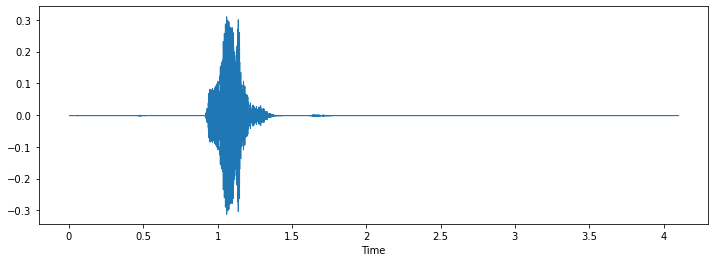

In [409]:
### Lets plot the librosa audio data (Original audio of sound)
plt.figure(figsize=(12, 4))
librosa_audio_data, librosa_sr=librosa.load(filename_audio_file)
librosa.display.waveshow(librosa_audio_data,sr=librosa_sr)
ipd.Audio(filename_audio_file)
### sampling is the reduction of a continuous-time signal to a discrete-time signal. 
### Explanation of the sampling rate in Librosa
    ## In Librosa By default we are using the sampling rate that has the number of 22050 ==>22,050 Hz
    ## Convert anay type of channel(mono or stereo) to mono channel(one signal)
    

In [6]:
### Here Librosa converts the signal to mono, meaning the channel will be a vector with one dimension and frequency is 22050

In [410]:
print("The simpling rate is :",librosa_sr)

The simpling rate is : 22050


In [411]:
print("The audio data :",librosa_audio_data)

The audio data : [0. 0. 0. ... 0. 0. 0.]


In [412]:
# Using scipy to see the difference.
scipy_sr, scipy_audio = wav.read(filename_audio_file)

In [413]:
print("The simpling rate is :",scipy_sr)

The simpling rate is : 48000


In [414]:
print("The audio data is :",scipy_audio)

The audio data is : [[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


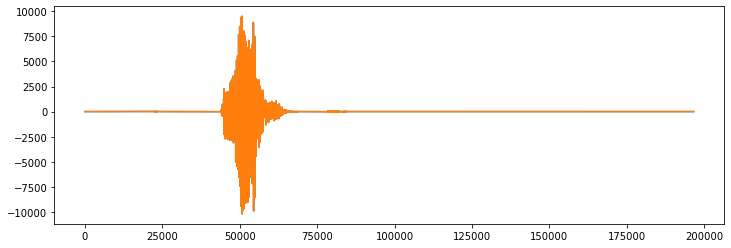

In [415]:
### Lets plot the scipy audio data (Original audio of sound with 2 channels )
plt.figure(figsize=(12, 4))
plt.plot(scipy_audio)

## I.2- Metadata upload

In [416]:
metadata=pd.read_csv('DARIJA Datasets 2022/metadata/DARIJA_DIGITS.csv')
metadata.shape

(315, 8)

In [418]:
metadata[:10]

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,record__0__1.wav,1,0.0,4.0,1,1,0,ZERO
1,record__0__2.wav,2,0.0,4.0,1,1,0,ZERO
2,record__0__3.wav,3,0.0,4.0,1,1,0,ZERO
3,record__0__4.wav,4,0.0,4.0,1,1,0,ZERO
4,record__0__5.wav,5,0.0,4.0,1,1,0,ZERO
5,record__0__6.wav,6,0.0,4.0,1,1,0,ZERO
6,record__0__7.wav,7,0.0,4.0,1,1,0,ZERO
7,record__0__8.wav,8,0.0,4.0,1,1,0,ZERO
8,record__0__9.wav,9,0.0,4.0,1,1,0,ZERO
9,record__0__10.wav,10,0.0,4.0,1,1,0,ZERO


In [419]:
### Check whether the dataset is embalenced 
print(metadata['class'].value_counts())

WAHD    109
JOJ     104
ZERO    102
Name: class, dtype: int64


## I.3- Data augmentation

### I.3.a- Adding white noise

In [420]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title="Original signal")
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title="Augmented signal")
    plt.show()

In [421]:
import random
import soundfile as sf

def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

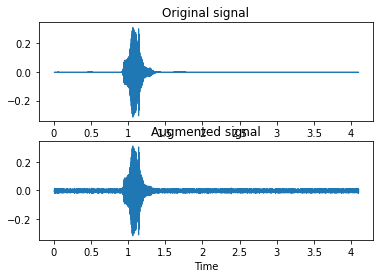

In [422]:
signal, sr = librosa.load(filename_audio_file)
augmented_signal = add_white_noise(signal, 0.2)
sf.write("DARIJA Datasets 2022/augmented_audio.wav", augmented_signal, sr)
_plot_signal_and_augmented_signal(signal, augmented_signal, sr)

In [200]:
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    signal, sr = librosa.load(file_name)
    augmented_signal = add_white_noise(signal, 0.2)
    file_name_aug = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str("AUG_" + row["slice_file_name"]))
    sf.write(file_name_aug, augmented_signal, sr)

315it [02:51,  1.83it/s]


### I.3.b- Time stretching

In [423]:
def time_stretch(signal, time_stretch_rate):
    """Time stretching implemented with librosa:
    https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
    """
    return librosa.effects.time_stretch(signal, time_stretch_rate)

<ipython-input-423-03db1d612df3>:5: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(signal, time_stretch_rate)


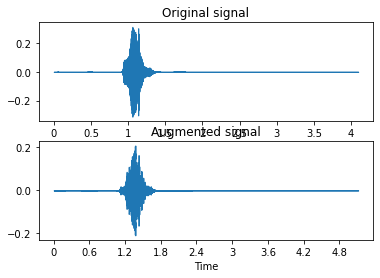

In [424]:
signal, sr = librosa.load(filename_audio_file)
augmented_signal = time_stretch(signal, 0.8)
sf.write("DARIJA Datasets 2022/time_stretch_audio.wav", augmented_signal, sr)
_plot_signal_and_augmented_signal(signal, augmented_signal, sr)

In [206]:
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    signal, sr = librosa.load(file_name)
    augmented_signal = time_stretch(signal, 0.8)
    file_name_aug = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str("TS_" + row["slice_file_name"]))
    sf.write(file_name_aug, augmented_signal, sr)

0it [00:00, ?it/s]<ipython-input-202-03db1d612df3>:5: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  return librosa.effects.time_stretch(signal, time_stretch_rate)
315it [03:28,  1.51it/s]


### I.3.c- Random gain

In [425]:
def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal

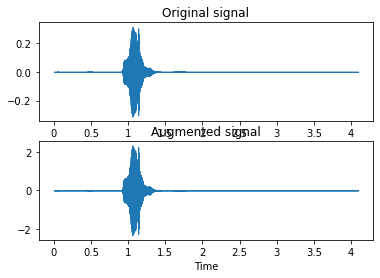

In [209]:
signal, sr = librosa.load(filename_audio_file)
augmented_signal = random_gain(signal,2,8)
sf.write("DARIJA Datasets 2022/random_gain_audio.wav", augmented_signal, sr)
_plot_signal_and_augmented_signal(signal, augmented_signal, sr)

In [426]:
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    signal, sr = librosa.load(file_name)
    augmented_signal = random_gain(signal, 2,8)
    file_name_aug = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str("RG_" + row["slice_file_name"]))
    sf.write(file_name_aug, augmented_signal, sr)

315it [02:37,  2.00it/s]


## I.4- Extract Features
Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples.
The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

### I.4.a- Extract Features for one audio file

In [427]:
### For the features extraction we are using MFCC with number 40, meaning 40 features.
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sr, n_mfcc=40)
print(mfccs.shape)
# The first dimension (40) is the number of MFCC coefficients,
# The second dimensions (177) is the number of time frames.(given by the length of the audio (in samples) divided by the hop_length)

(40, 177)


In [428]:
mfccs

array([[-650.6405, -650.6405, -650.6405, ..., -650.6405, -650.6405,
        -650.6405],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       ...,
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ],
       [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
           0.    ]], dtype=float32)

### I.4.b- Extract Features for every audio file

In [429]:
#### Extracting MFCC's For every audio file
audio_dataset_path='DARIJA Datasets 2022/audio/'
metadata=pd.read_csv('DARIJA Datasets 2022/metadata/DARIJA_DIGITS.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,record__0__1.wav,1,0.0,4.0,1,1,0,ZERO
1,record__0__2.wav,2,0.0,4.0,1,1,0,ZERO
2,record__0__3.wav,3,0.0,4.0,1,1,0,ZERO
3,record__0__4.wav,4,0.0,4.0,1,1,0,ZERO
4,record__0__5.wav,5,0.0,4.0,1,1,0,ZERO


In [430]:
# Create a function to do the work of features extraction
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [431]:
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    ### our labels ==> independant data 
    final_class_labels=row["class"]
    ### our features ==> dependants data 
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

315it [00:36,  8.68it/s]


In [432]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df[120:130]

,feature,class
120,"[-677.6584, 31.576431, -4.3933854, 5.841721, -...",WAHD
121,"[-661.3512, 25.694035, -2.901582, 2.9683955, -...",WAHD
122,"[-675.76874, 34.198307, -1.5822277, 6.844419, ...",WAHD
123,"[-495.42807, 37.608246, -16.299793, -3.1181223...",WAHD
124,"[-693.2002, 27.414124, -3.8567579, 6.155724, -...",WAHD
125,"[-800.11066, 36.422897, -10.194474, 5.2110467,...",WAHD
126,"[-675.65344, 22.4652, -3.887989, -1.2049795, -...",WAHD
127,"[-698.61597, 24.518496, -2.9517264, 1.0022422,...",WAHD
128,"[-692.5309, 23.657463, -6.5251737, -1.3193145,...",WAHD
129,"[-713.0911, 24.486221, -2.864347, 3.0509274, -...",WAHD


# II- Data preparation

In this chapter, final data preparation steps are taken before we use the data for model **traning** and **testing**.

These steps include:

* Label encoding
* Data splitting

In [172]:
### Split the dataframe into independent and dependent datasets(labels and features)

In [173]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [343]:
X.shape

(315, 40)

In [433]:
y.shape

(315,)

## I.5- Label Encoder using to_categorical

In [434]:
labelencoder=LabelEncoder()
y_encoded=to_categorical(labelencoder.fit_transform(y))

In [435]:
y_encoded.shape

(315, 3)

## I.6- Split the dataset to train and test

In [450]:
#X_train,X_test,y_train,y_test= train_test_split(np.array(X),y_encoded, test_size=0.20, random_state=9)

# Split the training, validating, and testing sets
number_of_samples = X.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

# create train, validation and test split
#X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25)
#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [322]:
y_encoded.shape

(315, 3)

In [323]:
X_train.shape

(252, 40)

In [324]:
X_test.shape

(63, 40)

In [325]:
y_train.shape

(252, 3)

In [326]:
y_test.shape

(63, 3)

# II- Model Creation 

In [451]:
#Find the number of labels to do the rest of the work automatically
num_labels=y_encoded.shape[1]
num_labels

3

## II.1- ANN model

### II.1.a- The proposed model

In [328]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

### II.1.b- The model summary

In [329]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 100)               4100      
                                                                 
 activation_8 (Activation)   (None, 100)               0         
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_27 (Dense)            (None, 200)               20200     
                                                                 
 activation_9 (Activation)   (None, 200)               0         
                                                                 
 dropout_16 (Dropout)        (None, 200)               0         
                                                                 
 dense_28 (Dense)            (None, 100)             

### II.1.c- Model compiling

In [330]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

### II.1.d- Model Training

In [331]:
## Trianing my model
num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/speech_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
7/8 [=========================>....] - ETA: 0s - loss: 54.8932 - accuracy: 0.3661
Epoch 00001: val_loss improved from inf to 8.30782, saving model to saved_models\speech_classification.hdf5
8/8 [==============================] - 2s 126ms/step - loss: 54.6652 - accuracy: 0.3492 - val_loss: 8.3078 - val_accuracy: 0.3175
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 55.1196 - accuracy: 0.2812
Epoch 00002: val_loss improved from 8.30782 to 2.12997, saving model to saved_models\speech_classification.hdf5
8/8 [==============================] - 0s 43ms/step - loss: 51.6893 - accuracy: 0.3016 - val_loss: 2.1300 - val_accuracy: 0.1111
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 45.8571 - accuracy: 0.2500
Epoch 00003: val_loss did not improve from 2.12997
8/8 [==============================] - 0s 10ms/step - loss: 37.3332 - accuracy: 0.3095 - val_loss: 4.6070 - val_accuracy: 0.3175
Epoch 4/100
1/8 [==>...........................] - ETA: 0s 

1/8 [==>...........................] - ETA: 0s - loss: 2.4704 - accuracy: 0.3750
Epoch 00029: val_loss did not improve from 1.03314
8/8 [==============================] - 0s 11ms/step - loss: 2.1247 - accuracy: 0.4246 - val_loss: 1.0896 - val_accuracy: 0.3175
Epoch 30/100
1/8 [==>...........................] - ETA: 0s - loss: 2.2550 - accuracy: 0.3125
Epoch 00030: val_loss did not improve from 1.03314
8/8 [==============================] - 0s 8ms/step - loss: 2.3766 - accuracy: 0.3571 - val_loss: 1.0905 - val_accuracy: 0.3175
Epoch 31/100
1/8 [==>...........................] - ETA: 0s - loss: 2.8245 - accuracy: 0.2500
Epoch 00031: val_loss did not improve from 1.03314
8/8 [==============================] - 0s 8ms/step - loss: 2.5117 - accuracy: 0.3730 - val_loss: 1.0907 - val_accuracy: 0.5238
Epoch 32/100
1/8 [==>...........................] - ETA: 0s - loss: 2.8814 - accuracy: 0.2812
Epoch 00032: val_loss did not improve from 1.03314
8/8 [==============================] - 0s 9ms/step 

1/8 [==>...........................] - ETA: 0s - loss: 1.1749 - accuracy: 0.3750
Epoch 00059: val_loss did not improve from 1.03314
8/8 [==============================] - 0s 8ms/step - loss: 1.2559 - accuracy: 0.4206 - val_loss: 1.0690 - val_accuracy: 0.6508
Epoch 60/100
1/8 [==>...........................] - ETA: 0s - loss: 0.9333 - accuracy: 0.4688
Epoch 00060: val_loss did not improve from 1.03314
8/8 [==============================] - 0s 9ms/step - loss: 1.1632 - accuracy: 0.3968 - val_loss: 1.0670 - val_accuracy: 0.6508
Epoch 61/100
1/8 [==>...........................] - ETA: 0s - loss: 1.2138 - accuracy: 0.3125
Epoch 00061: val_loss did not improve from 1.03314
8/8 [==============================] - 0s 9ms/step - loss: 1.3303 - accuracy: 0.3611 - val_loss: 1.0618 - val_accuracy: 0.5556
Epoch 62/100
1/8 [==>...........................] - ETA: 0s - loss: 1.3727 - accuracy: 0.3438
Epoch 00062: val_loss did not improve from 1.03314
8/8 [==============================] - 0s 8ms/step -

1/8 [==>...........................] - ETA: 0s - loss: 0.8143 - accuracy: 0.5312
Epoch 00086: val_loss improved from 0.87898 to 0.87161, saving model to saved_models\speech_classification.hdf5
8/8 [==============================] - 0s 30ms/step - loss: 0.9481 - accuracy: 0.4841 - val_loss: 0.8716 - val_accuracy: 0.6667
Epoch 87/100
1/8 [==>...........................] - ETA: 0s - loss: 0.9649 - accuracy: 0.3750
Epoch 00087: val_loss improved from 0.87161 to 0.86184, saving model to saved_models\speech_classification.hdf5
8/8 [==============================] - 0s 32ms/step - loss: 0.9484 - accuracy: 0.4563 - val_loss: 0.8618 - val_accuracy: 0.6508
Epoch 88/100
1/8 [==>...........................] - ETA: 0s - loss: 0.9069 - accuracy: 0.4062
Epoch 00088: val_loss improved from 0.86184 to 0.86020, saving model to saved_models\speech_classification.hdf5
8/8 [==============================] - 0s 36ms/step - loss: 0.9669 - accuracy: 0.5238 - val_loss: 0.8602 - val_accuracy: 0.6667
Epoch 89/10

### II.1.e- Model Accuracy

In [332]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.6666666865348816


### II.1.f- Testing Some Audio Data

Steps
- Preprocess the new audio data
- predict the classes
- Invere transform the Predicted Label 

In [333]:
filename="DARIJA Datasets 2022/record__0__6.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predict_x=model.predict(mfccs_scaled_features)
predicted_label=np.argmax(predict_x,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-5.48686157e+02  7.16881714e+01 -1.26597786e+01  1.02699690e+01
  1.79475231e+01  5.15265417e+00 -6.09058666e+00 -4.25234169e-01
 -1.43019128e+00  4.90580368e+00 -6.33316875e-01 -7.44661188e+00
 -2.55339932e+00  3.91758978e-01 -5.52243900e+00  1.15831220e+00
  1.09603918e+00 -1.05664656e-01 -8.34825158e-01  2.28484333e-01
 -4.46164417e+00  1.61268044e+00  3.09822168e-02 -4.56214476e+00
 -9.48102698e-02  9.98021424e-01 -1.82922572e-01 -2.05609894e+00
 -3.31790733e+00 -5.24907470e-01 -1.46052754e+00 -2.34328318e+00
 -1.10712874e+00  1.90677106e+00  3.44274715e-02 -1.49627256e+00
  1.32133663e+00  9.48599577e-01 -4.26098526e-01 -2.49279881e+00]
[[-5.48686157e+02  7.16881714e+01 -1.26597786e+01  1.02699690e+01
   1.79475231e+01  5.15265417e+00 -6.09058666e+00 -4.25234169e-01
  -1.43019128e+00  4.90580368e+00 -6.33316875e-01 -7.44661188e+00
  -2.55339932e+00  3.91758978e-01 -5.52243900e+00  1.15831220e+00
   1.09603918e+00 -1.05664656e-01 -8.34825158e-01  2.28484333e-01
  -4.46164417e+00  

array(['ZERO'], dtype='<U4')

# III.2 RNN simple Model

## Create network

In [472]:
# Define the LSTM model
def create_model_SimpleRNN():
    
    # Build network topology
    model = Sequential()
    
    # LSTM layers
    model.add(SimpleRNN(128, return_sequences=False,activation = 'tanh', input_shape=(40, 1)))
    
    # Dense layer
    model.add(Dense(64))
    # Add a dropout layer (penalizing more complex models) -- prevents overfitting
    model.add(Dropout(0.3))
    
    # output layer
    model.add(Dense(num_labels))
    model.add(Activation('softmax')) # softmax to do multiclasification task
    return model

In [475]:
model_SimpleRNN = create_model_SimpleRNN()

In [380]:
# create network
import tensorflow.keras as keras

# build network topology
model = keras.Sequential()

# 2 LSTM layers
model.add(keras.layers.LSTM(64, input_shape=(40,1), return_sequences=True))


# dense layer
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.3))

# output layer
model.add(keras.layers.Dense(num_labels, activation='softmax'))
    
#input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
#model = build_model(X_train.shape)


## Compile Model 

In [476]:
# compile model
# Evaluating loss function of MSE using the adam optimizer.
model_SimpleRNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [477]:
model_SimpleRNN.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense_50 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 3)                 195       
                                                                 
 activation_22 (Activation)  (None, 3)                 0         
                                                                 
Total params: 25,091
Trainable params: 25,091
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [478]:
# train model
#history = model.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=32, epochs=30)

num_epochs = 100
num_batch_size = 32
X_train = np.expand_dims(X[:training_samples],-1)
y_train = y_encoded[:training_samples]
y_validation = y_encoded[training_samples:training_samples+validation_samples]
X_validation = np.expand_dims(X[training_samples:training_samples+validation_samples],-1)

In [482]:
history_model_SimpleRNN = model_SimpleRNN.fit(X_train,y_train,validation_data=(X_validation,y_validation),
                      epochs=num_epochs, batch_size=num_batch_size)

Epoch 1/100
8/8 [==============================] - 0s 29ms/step - loss: 1.0740e-05 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 1.0604e-05 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 8.2965e-05 - accuracy: 1.0000 - val_loss: 0.0608 - val_accuracy: 0.8710
Epoch 4/100
8/8 [==============================] - 0s 25ms/step - loss: 4.6684e-05 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 0.9677
Epoch 5/100
8/8 [==============================] - 0s 24ms/step - loss: 3.8871e-04 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9355
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 0.0130 - accuracy: 0.9722 - val_loss: 0.2960 - val_accuracy: 0.3871
Epoch 7/100
8/8 [==============================] - 0s 24ms/step - loss: 0.0347 - accuracy: 0.9325 - val_loss: 0.0149 - val_accuracy: 0.9677


Epoch 58/100
8/8 [==============================] - 0s 25ms/step - loss: 6.3372e-07 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9355
Epoch 59/100
8/8 [==============================] - 0s 23ms/step - loss: 1.6996e-06 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9355
Epoch 60/100
8/8 [==============================] - 0s 23ms/step - loss: 1.3689e-06 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9355
Epoch 61/100
8/8 [==============================] - 0s 23ms/step - loss: 3.1888e-06 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9355
Epoch 62/100
8/8 [==============================] - 0s 27ms/step - loss: 1.4356e-06 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9355
Epoch 63/100
8/8 [==============================] - 0s 22ms/step - loss: 1.1133e-06 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9355
Epoch 64/100
8/8 [==============================] - 0s 19ms/step - loss: 4.5295e-07 - accuracy: 1.0000 - val_loss: 0.0430 - val_ac

## Plot Accuracy/error for training and validation

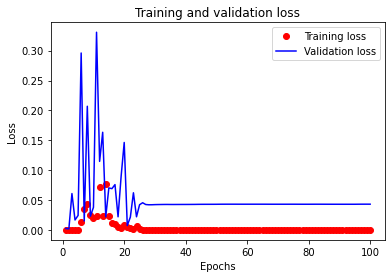

In [485]:
### loss plots using LSTM model
loss = history_model_SimpleRNN.history['loss']
val_loss = history_model_SimpleRNN.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

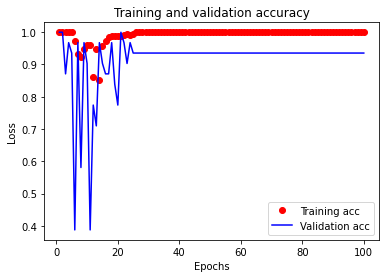

In [486]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history_model_SimpleRNN.history['accuracy']
val_acc = history_model_SimpleRNN.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Evaluation Model on test set

In [489]:
test_accuracy=model_SimpleRNN.evaluate(X_validation,y_validation,verbose=0)
print(test_accuracy[1])

0.9354838728904724


In [ ]:
model_SimpleRNN.evaluate(
    np.expand_dims(X[training_samples + validation_samples:], -1), 
                 y_encoded[training_samples + validation_samples:]
)

In [492]:
filename="DARIJA Datasets 2022/record__2__314.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predict_x=model_SimpleRNN.predict(mfccs_scaled_features)
predicted_label=np.argmax(predict_x,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-5.3940051e+02  3.0429661e+01  3.6579447e+00  6.5446029e+00
 -4.8269415e-01  1.3557437e-01 -2.8373556e+00 -1.7718567e+00
 -3.1499131e+00 -7.4981418e+00 -5.5374360e+00 -7.9037395e+00
 -4.1369591e+00 -4.0199313e+00 -4.6120672e+00  5.3613245e-01
 -1.2450334e+00 -1.7452793e+00 -1.7348813e+00 -2.6375220e+00
 -2.5782754e+00 -2.7134604e+00 -8.8780445e-01 -9.8766226e-01
 -1.6758242e+00 -1.1826403e+00 -1.3739077e+00 -1.3863598e+00
 -7.0197254e-01 -1.2251030e+00 -1.8793662e+00 -1.4245540e+00
 -1.8528637e+00 -1.4994972e+00 -9.0641856e-01 -1.0776002e+00
 -2.0781336e+00 -2.6756523e+00 -1.0989040e+00 -1.5690364e+00]
[[-5.3940051e+02  3.0429661e+01  3.6579447e+00  6.5446029e+00
  -4.8269415e-01  1.3557437e-01 -2.8373556e+00 -1.7718567e+00
  -3.1499131e+00 -7.4981418e+00 -5.5374360e+00 -7.9037395e+00
  -4.1369591e+00 -4.0199313e+00 -4.6120672e+00  5.3613245e-01
  -1.2450334e+00 -1.7452793e+00 -1.7348813e+00 -2.6375220e+00
  -2.5782754e+00 -2.7134604e+00 -8.8780445e-01 -9.8766226e-01
  -1.6758242e+00 

array(['JOJ'], dtype='<U4')

# III.3 LSTM Model

## Create network

In [493]:
# Define the LSTM model
def create_model_LSTM():
    
    # Build network topology
    model = Sequential()
    
    # LSTM layers
    model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
    
    # Dense layer
    model.add(Dense(64))
    model.add(Dropout(0.3))
    
    # output layer
    model.add(Dense(3))
    model.add(Activation('softmax'))
    return model


In [494]:
model_LSTM = create_model_LSTM()

## Compile Model 

In [495]:
# compile model
#optimiser = keras.optimizers.Adam(learning_rate=0.0001)
#model_LSTM.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_LSTM.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Train Model

In [496]:
num_epochs = 100
num_batch_size = 32
X_train = np.expand_dims(X[:training_samples],-1)
y_train = y_encoded[:training_samples]
y_validation = y_encoded[training_samples:training_samples+validation_samples]
X_validation = np.expand_dims(X[training_samples:training_samples+validation_samples],-1)



In [497]:
history_model_LSTM = model_LSTM.fit(X_train,y_train,validation_data=(X_validation,y_validation),
                      epochs=num_epochs, shuffle=True, batch_size=num_batch_size)

Epoch 1/100
8/8 [==============================] - 7s 223ms/step - loss: 1.0395 - accuracy: 0.5317 - val_loss: 1.7230 - val_accuracy: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 0s 60ms/step - loss: 0.9891 - accuracy: 0.5635 - val_loss: 1.4246 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 0s 53ms/step - loss: 0.8433 - accuracy: 0.7103 - val_loss: 1.6611 - val_accuracy: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 0s 57ms/step - loss: 0.5157 - accuracy: 0.7937 - val_loss: 1.2938 - val_accuracy: 0.0000e+00
Epoch 5/100
8/8 [==============================] - 0s 58ms/step - loss: 0.4187 - accuracy: 0.8254 - val_loss: 1.3194 - val_accuracy: 0.0000e+00
Epoch 6/100
8/8 [==============================] - 0s 62ms/step - loss: 0.3659 - accuracy: 0.8294 - val_loss: 1.2723 - val_accuracy: 0.0000e+00
Epoch 7/100
8/8 [==============================] - 0s 56ms/step - loss: 0.4984 - accuracy: 0.8095 - val_loss: 1.4801 - val_accuracy: 0.

8/8 [==============================] - 0s 58ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.0620 - val_accuracy: 0.9677
Epoch 59/100
8/8 [==============================] - 0s 56ms/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.1281 - val_accuracy: 0.9677
Epoch 60/100
8/8 [==============================] - 0s 61ms/step - loss: 0.0166 - accuracy: 0.9960 - val_loss: 0.0557 - val_accuracy: 0.9677
Epoch 61/100
8/8 [==============================] - 0s 63ms/step - loss: 0.1546 - accuracy: 0.9484 - val_loss: 0.1316 - val_accuracy: 0.9677
Epoch 62/100
8/8 [==============================] - 0s 61ms/step - loss: 0.3875 - accuracy: 0.8968 - val_loss: 0.8842 - val_accuracy: 0.6452
Epoch 63/100
8/8 [==============================] - 0s 62ms/step - loss: 0.2797 - accuracy: 0.8929 - val_loss: 0.3374 - val_accuracy: 0.9677
Epoch 64/100
8/8 [==============================] - 0s 55ms/step - loss: 0.1630 - accuracy: 0.9524 - val_loss: 0.2271 - val_accuracy: 0.9677
Epoch 65/100
8/8 [========

## Plot Accuracy/loss for training and validation

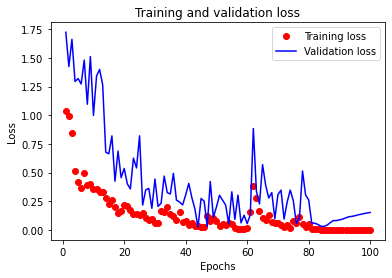

In [498]:
### loss plots using LSTM model
loss = history_model_LSTM.history['loss']
val_loss = history_model_LSTM.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

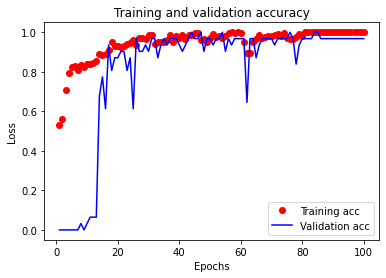

In [499]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history_model_LSTM.history['accuracy']
val_acc = history_model_LSTM.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Evaluation Model on test set

In [500]:
test_accuracy=model_LSTM.evaluate(X_validation,y_validation,verbose=0)
print(test_accuracy[1])

0.9677419066429138


In [501]:
model_LSTM.evaluate(
    np.expand_dims(X[training_samples + validation_samples:], -1), 
                 y_encoded[training_samples + validation_samples:]
)

1/1 [==============================] - 1s 1s/step - loss: 0.0123 - accuracy: 1.0000


[0.012270677834749222, 1.0]

In [502]:
filename="DARIJA Datasets 2022/record__2__314.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predict_x=model_LSTM.predict(mfccs_scaled_features)
predicted_label=np.argmax(predict_x,axis=1)
print(predicted_label)
prediction_class = labelencoder.inverse_transform(predicted_label) 
prediction_class

[-5.3940051e+02  3.0429661e+01  3.6579447e+00  6.5446029e+00
 -4.8269415e-01  1.3557437e-01 -2.8373556e+00 -1.7718567e+00
 -3.1499131e+00 -7.4981418e+00 -5.5374360e+00 -7.9037395e+00
 -4.1369591e+00 -4.0199313e+00 -4.6120672e+00  5.3613245e-01
 -1.2450334e+00 -1.7452793e+00 -1.7348813e+00 -2.6375220e+00
 -2.5782754e+00 -2.7134604e+00 -8.8780445e-01 -9.8766226e-01
 -1.6758242e+00 -1.1826403e+00 -1.3739077e+00 -1.3863598e+00
 -7.0197254e-01 -1.2251030e+00 -1.8793662e+00 -1.4245540e+00
 -1.8528637e+00 -1.4994972e+00 -9.0641856e-01 -1.0776002e+00
 -2.0781336e+00 -2.6756523e+00 -1.0989040e+00 -1.5690364e+00]
[[-5.3940051e+02  3.0429661e+01  3.6579447e+00  6.5446029e+00
  -4.8269415e-01  1.3557437e-01 -2.8373556e+00 -1.7718567e+00
  -3.1499131e+00 -7.4981418e+00 -5.5374360e+00 -7.9037395e+00
  -4.1369591e+00 -4.0199313e+00 -4.6120672e+00  5.3613245e-01
  -1.2450334e+00 -1.7452793e+00 -1.7348813e+00 -2.6375220e+00
  -2.5782754e+00 -2.7134604e+00 -8.8780445e-01 -9.8766226e-01
  -1.6758242e+00 

array(['JOJ'], dtype='<U4')

# III.3 GRU Model

# VI Model comparison